In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

#üzerinde önişleme yaptığım verisetime eriştim.
df = pd.read_excel("DATASET_LASTFORM.xlsx")


In [ ]:
#sayısal sütunlarım
numeric_columns = [
    'durationInMs', 'copyDuration', 'dataRead', 'dataWritten',
    'durationInQueue', 'queueDuration', 'transferDuration', 'totalDuration',
    'rowsCopied', 'rowsRead', 'throughput'
]

df_numeric = df[numeric_columns]

#İstatistiksel işlemleri yaptırıyorum.
summary = df_numeric.agg(['mean', 'median', 'var', 'min', 'max']).transpose()

#Okunulabilir hale getiriyorum.
summary.columns = ['Ortalama', 'Medyan', 'Varyans', 'Min', 'Max']

print(summary)


                      Ortalama     Medyan       Varyans     Min           Max
durationInMs      4.444385e+05  186952.00  2.268264e+11  1027.0  2.372161e+06
copyDuration      5.062601e+02     354.00  2.322901e+05     9.0  2.365000e+03
dataRead          1.026476e+07    2192.00  1.702277e+16     0.0  4.102667e+09
dataWritten       7.865224e+06    2297.00  4.884447e+15     0.0  1.293849e+09
durationInQueue   4.609960e+02     279.00  2.134542e+05     0.0  1.285000e+03
queueDuration     4.623524e+02     279.00  2.127792e+05     0.0  1.378000e+03
transferDuration  3.104614e+01      13.00  7.690920e+03     0.0  1.487000e+03
totalDuration     5.056380e+02     354.00  2.316613e+05     9.0  2.365000e+03
rowsCopied        3.154805e+04      11.00  9.771543e+10     0.0  6.626231e+06
rowsRead          3.127271e+04       9.00  9.775462e+10     0.0  6.626231e+06
throughput        9.195390e+01       0.17  1.652861e+05     0.0  7.848666e+03


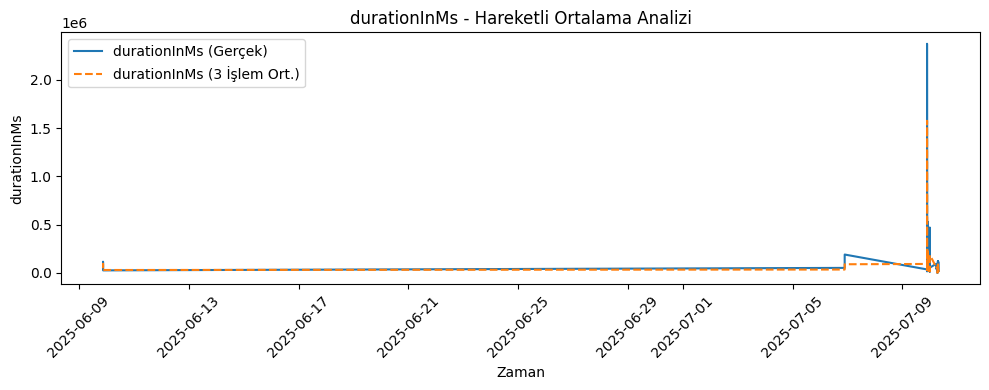

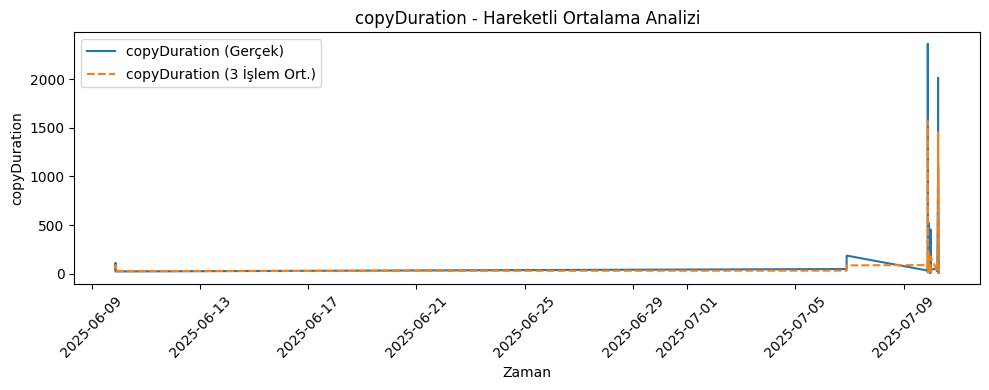

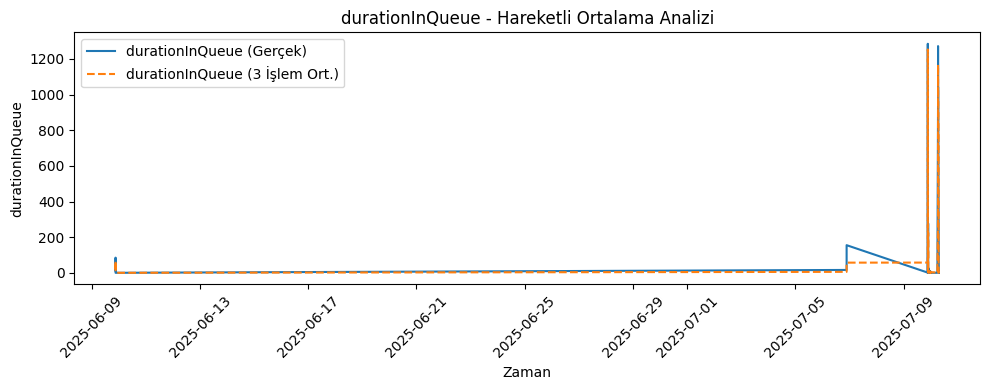

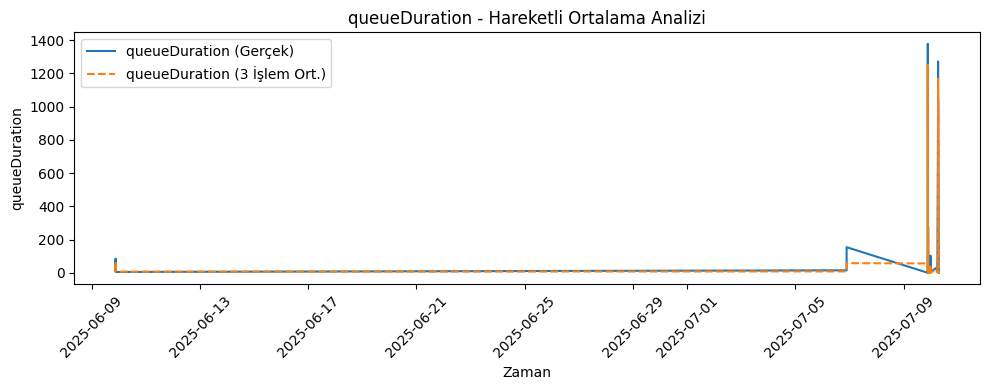

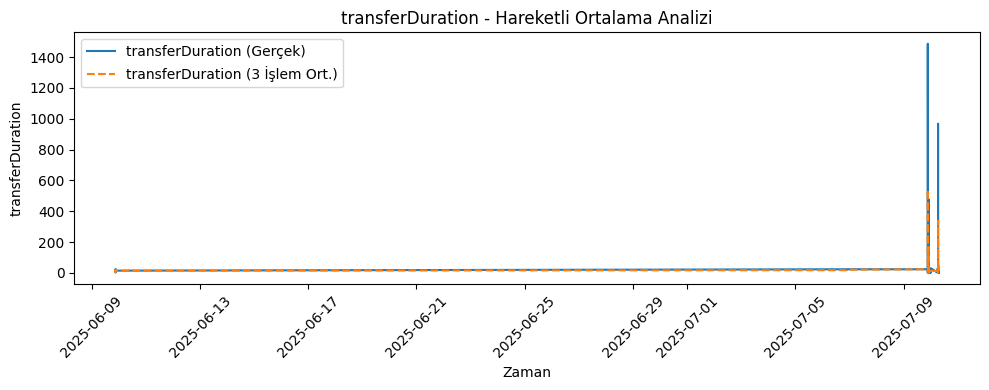

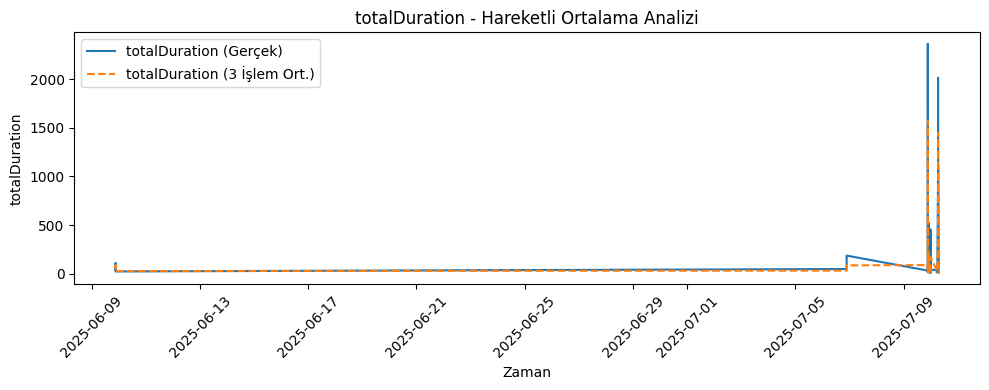

In [ ]:
#Zaman sütununu datetime'a çevirdim.
df['activityRunStart'] = pd.to_datetime(df['activityRunStart'])

#Zamana göre sıralama yapıyorum.
df = df.sort_values('activityRunStart')

#Duration sütunları
columns = [
    'durationInMs', 'copyDuration',
    'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration'
]

# Her biri için rolling average hesaplayıp görselini çizdiriyorum.
for col in columns:
    df[f'{col}_ma'] = df[col].rolling(window=3).mean()

    plt.figure(figsize=(10, 4))
    plt.plot(df['activityRunStart'], df[col], label=f'{col} (Gerçek)')
    plt.plot(df['activityRunStart'], df[f'{col}_ma'], label=f'{col} (3 İşlem Ort.)', linestyle='--')
    plt.title(f"{col} - Hareketli Ortalama Analizi")
    plt.xlabel("Zaman")
    plt.ylabel(col)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#ETL süreci içinde dengesizlik, yavaşlama, abi sıçramalar var mı yoksa düzenli mi çalışıyor tespit edebilirim.

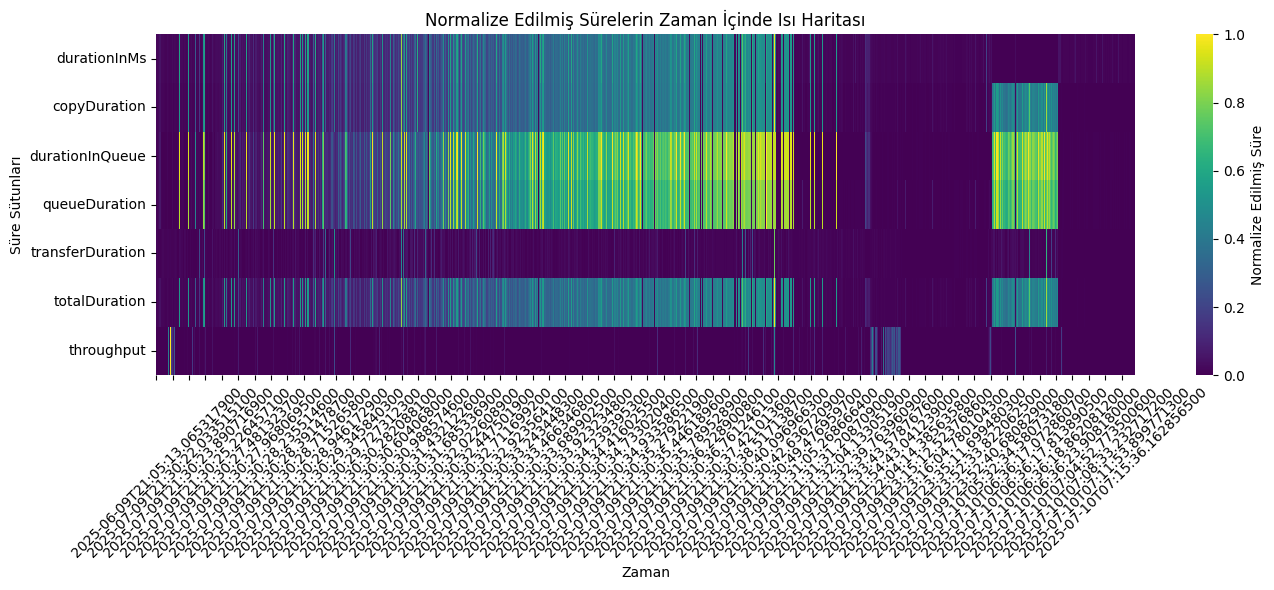

In [ ]:
#sayısal sütunlarım
duration_columns = [
    'durationInMs', 'copyDuration',
    'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration' , 'throughput'
]
#Zaman sütununu datetime'a çevirdim.
df['activityRunStart'] = pd.to_datetime(df['activityRunStart'])
df = df.sort_values('activityRunStart')

#Her sütunu ayrı ayrı normalize etmek için MinMaxScaler ve boş bir sözlük
scaler = MinMaxScaler()
scaled_columns = {}

for col in duration_columns:
    col_values = df[[col]].fillna(0)
    scaled_col = scaler.fit_transform(col_values)
    scaled_columns[col] = scaled_col.flatten()

scaled_df = pd.DataFrame(scaled_columns)
scaled_df['time'] = df['activityRunStart'].values
scaled_df.set_index('time', inplace=True)

# Isı haritası çizimi
plt.figure(figsize=(14, 6))
sns.heatmap(scaled_df.T, cmap='viridis', cbar_kws={'label': 'Normalize Edilmiş Süre'})
plt.title("Normalize Edilmiş Sürelerin Zaman İçinde Isı Haritası")
plt.xlabel("Zaman")
plt.ylabel("Süre Sütunları")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Zamanla birlikte ETL sürecine ait sürelerin (duration’ların) nasıl değiştiğini tek bir bakışta, renklerle görmemizi sağlıyor.


In [ ]:
# Süre sütunları
duration_columns = [
    'durationInMs', 'copyDuration',
    'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration'
]

# Eksik değerleri 0 ile doldur
df_clean = df[duration_columns].fillna(0)

# Z-score hesapla
z_scores = df_clean.apply(zscore)

# Her sütun için anomali kontrolü ve indeks yazdırma
for col in duration_columns:
    anomalies = z_scores[col].abs() > 3
    anomaly_count = anomalies.sum()

    if anomaly_count > 0:
        anomaly_indices = df.index[anomalies].tolist()
        print(f"{col} sütununda {anomaly_count} adet anomali var.")
        print(f"Anomali olan satırların indeksleri:\n{anomaly_indices}\n")
    else:
        print(f"{col} sütununda anomali yok.\n")


durationInMs sütununda 4 adet anomali var.
Anomali olan satırların indeksleri:
[740, 736, 317, 810]

copyDuration sütununda 5 adet anomali var.
Anomali olan satırların indeksleri:
[740, 736, 317, 810, 259]

durationInQueue sütununda anomali yok.

queueDuration sütununda anomali yok.

transferDuration sütununda 19 adet anomali var.
Anomali olan satırların indeksleri:
[124, 748, 126, 642, 159, 641, 740, 127, 775, 786, 736, 317, 245, 844, 842, 810, 811, 244, 259]

totalDuration sütununda 5 adet anomali var.
Anomali olan satırların indeksleri:
[740, 736, 317, 810, 259]



In [ ]:
#0 olanları NaN yapıyorum.
rowsRead_replaced = df['rowsRead'].replace(0, np.nan)
dataRead_replaced = df['dataRead'].replace(0, np.nan)

#Oranları hesaplıyorum.
df['copy_ratio'] = df['rowsCopied'] / rowsRead_replaced
#Bu oran 1’e çok yakınsa veri doğrudan kopyalanmış, düşükse çok fazla filtreleme yapılmış olabilir.
df['data_loss_ratio'] = df['dataWritten'] / dataRead_replaced
#Bu oran 1’e çok yakınsa okunan verinin tamamına yakınını yazmış demektir, düşükse veri kaybı ya da filtreleme yapılmış olabilir.

#NaN'ları 0 ile dolduruyorum.
df['copy_ratio'] = df['copy_ratio'].fillna(0)
df['data_loss_ratio'] = df['data_loss_ratio'].fillna(0)

# Sonuçları yazdırıyorum.
print("copy_ratio:")
print(df[['copy_ratio']].head(5))

print("\ndata_loss_ratio:")
print(df[['data_loss_ratio']].head(5))

#dataWritten > dataRead olan satırların kaç tane olduğunu görmek istedim.
mask = df['dataWritten'] > df['dataRead']
count = mask.sum()
print(f"dataWritten sütunu, dataRead sütunundan büyük olan {count} satır var.")

#Bu oranlar sayesinde veri aktarımının ne kadar verimli gerçekleştiğini görebiliyorum.


copy_ratio:
   copy_ratio
0         1.0
7         1.0
1         0.0
8         0.0
6         0.0

data_loss_ratio:
   data_loss_ratio
0         1.099174
7         1.099174
1         0.000000
8         0.000000
6         0.000000
dataWritten sütunu, dataRead sütunundan büyük olan 815 satır var.


In [ ]:
columns = [
    'durationInMs', 'copyDuration',
    'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration',
    'dataRead', 'dataWritten',
    'rowsCopied', 'rowsRead' , 'throughput'
]

# Gruplara ayırdım.
managed = df[df['integrationRuntime_type'] == 'Managed']
selfhosted = df[df['integrationRuntime_type'] == 'SelfHosted']

#integrationRuntime_type daki değerlere göre hangisinde süre ortalaması daha fazla bakıyorum.
for col in columns:
    managed_mean = managed[col].mean()
    selfhosted_mean = selfhosted[col].mean()

    if selfhosted_mean > managed_mean:
        print(f"SelfHosted'da {col} daha yüksek. ({selfhosted_mean:.2f} > {managed_mean:.2f})")
    elif managed_mean > selfhosted_mean:
        print(f"Managed'da {col} daha yüksek. ({managed_mean:.2f} > {selfhosted_mean:.2f})")
    else:
        print(f"{col} için her iki ortamda ortalama eşit.")


SelfHosted'da durationInMs daha yüksek. (508998.27 > 42609.66)
SelfHosted'da copyDuration daha yüksek. (581.62 > 37.21)
SelfHosted'da durationInQueue daha yüksek. (535.06 > 0.00)
SelfHosted'da queueDuration daha yüksek. (535.35 > 7.98)
SelfHosted'da transferDuration daha yüksek. (33.17 > 17.83)
SelfHosted'da totalDuration daha yüksek. (580.94 > 36.93)
SelfHosted'da dataRead daha yüksek. (10975219.91 > 5842770.69)
SelfHosted'da dataWritten daha yüksek. (8165019.34 > 5999254.37)
Managed'da rowsCopied daha yüksek. (31556.80 > 31546.65)
Managed'da rowsRead daha yüksek. (31455.51 > 31243.34)
SelfHosted'da throughput daha yüksek. (97.89 > 55.02)


In [ ]:
#Hedef sütunlar
columns = [
    'durationInMs', 'copyDuration',
    'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration',
    'dataRead', 'dataWritten',
    'rowsCopied', 'rowsRead' , 'throughput'
]

#En çok activityName'e sahip pipelineName'i buluyorum.
most_active_pipeline = df['pipelineName'].value_counts().idxmax()

#O pipeline'a ait aktiviteleri alıyorum.
pipeline_df = df[df['pipelineName'] == most_active_pipeline]

print(f"En çok activity içeren pipeline: {most_active_pipeline}\n")

#Her sütun için en yüksek değere sahip activityName'i buluyorum.
for col in columns:
    max_row = pipeline_df.loc[pipeline_df[col].idxmax()]
    print(f"{col} açısından en yüksek değere sahip activityName: {max_row['activityName']} (Değer: {max_row[col]})")

#En çok aktiviteye sahip olan pipeline’daki en yoğun işlem yapan aktiviteleri tespit etmiş oldum.


En çok activity içeren pipeline: Pja_Social_Recruiting_Jobs

durationInMs açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 121568)
copyDuration açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 19)
durationInQueue açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 8)
queueDuration açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 8)
transferDuration açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 4)
totalDuration açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 19)
dataRead açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 61926)
dataWritten açısından en yüksek değere sahip activityName: Copy Pja Jobs Load To Blob Storage (Değer: 33569)
rowsCopied açısından en yüksek değere sahip activityName: Copy Pja Jobs 

In [ ]:
#Status oranlarını hesaplayıp yazdırdım.
status_percent = df['status'].value_counts(normalize=True) * 100

print(status_percent.round(2))

#activitylerin ne kadar başarıyla çalıştığını gözlemliyorum.

status
Succeeded    98.97
Failed        1.03
Name: proportion, dtype: float64


In [ ]:
#activityType ve queueStatus eşleşmelerini gruplu olarak görmek için
eşleşmeler = df.groupby('activityType')['queueStatus'].unique()

#Sonuçlar
print("Her activityType için görülen queueStatus değerleri:")
print(eşleşmeler)

#Her aktivite türünün kuyruk durumlarıyla nasıl ilişkilendiğini anlayabildim.

Her activityType için görülen queueStatus değerleri:
activityType
Copy    [Completed]
Name: queueStatus, dtype: object


In [ ]:
#Her location için farklı billable_unit değerlerini buldum.
location_units = df.groupby('integrationRuntime_location')['billable_unit'].unique()
print("Her location için farklı billable_unit değerleri:\n")
print(location_units)

#Her location için ortalama interimDataWritten ve interimRowsCopied hesapladım.
averages = df.groupby('integrationRuntime_location')[['interimDataWritten', 'interimRowsCopied']].mean()

print("\nHer location için ortalama interimDataWritten ve interimRowsCopied:\n")
print(averages.round(2))

#En yüksek ortalamaya sahip location’ları buldum.
max_data_location = averages['interimDataWritten'].idxmax()
max_rows_location = averages['interimRowsCopied'].idxmax()

print(f"\nEn yüksek interimDataWritten ortalamasına sahip location: {max_data_location} ({averages.loc[max_data_location, 'interimDataWritten']:.2f})")
print(f"En yüksek interimRowsCopied ortalamasına sahip location: {max_rows_location} ({averages.loc[max_rows_location, 'interimRowsCopied']:.2f})")

#farklı çalışma konumlarının hem hangi ücretlendirme birimlerini kullandığını görebildim. hem de bu konumların ne kadar veri yazdığını ve satır kopyaladığını karşılaştırabildim.


Her location için farklı billable_unit değerleri:

integrationRuntime_location
On-prem           [Hours]
West Europe    [DIUHours]
Name: billable_unit, dtype: object

Her location için ortalama interimDataWritten ve interimRowsCopied:

                             interimDataWritten  interimRowsCopied
integrationRuntime_location                                       
On-prem                              8234295.18           31666.69
West Europe                          5999254.37           31556.80

En yüksek interimDataWritten ortalamasına sahip location: On-prem (8234295.18)
En yüksek interimRowsCopied ortalamasına sahip location: On-prem (31666.69)


In [ ]:
#dataConsistencyVerification değerlerinin dağılım yüzdesi
value_counts = df['dataConsistencyVerification'].value_counts(normalize=True) * 100
print("Veri setinde oranlar (%):")
print(value_counts)
print("\n")

#Her bir kategori için copyDuration ortalaması
avg_copy_duration = df.groupby('dataConsistencyVerification')['copyDuration'].mean()
print("CopyDuration ortalamaları:")
print(avg_copy_duration)
print("\n")

#Hangisi daha yüksek copyDuration ortalamasına sahipse onu yazdırıyorum.
higher_label = avg_copy_duration.idxmax()
higher_value = avg_copy_duration.max()

print(f"{higher_label} verileri daha fazla kopyalama süresi harcamış ({higher_value:.2f} ms ortalama ile).")

#Hangi tutarlılık kontrol durumunun veri aktarım süresini daha çok etkilediğini görebildim.

Veri setinde oranlar (%):
dataConsistencyVerification
NotVerified    96.499602
Unsupported     3.500398
Name: proportion, dtype: float64


CopyDuration ortalamaları:
dataConsistencyVerification
NotVerified    518.207749
Unsupported    176.886364
Name: copyDuration, dtype: float64


NotVerified verileri daha fazla kopyalama süresi harcamış (518.21 ms ortalama ile).


In [ ]:
#integrationRuntime_name sütunundaki her farklı değer için queueDuration ortalaması
avg_queue_duration = df.groupby('integrationRuntime_name')['queueDuration'].mean()

print("integrationRuntime_name değerlerine göre queueDuration ortalamaları:\n")
print(avg_queue_duration)

#Hangisi daha fazla kuyrukta bekleme süresi oluşturuyor anlayabildim.

integrationRuntime_name değerlerine göre queueDuration ortalamaları:

integrationRuntime_name
AutoResolveIntegrationRuntime      7.982759
CoensioIR                          7.000000
datalake-svc01                   535.841959
Name: queueDuration, dtype: float64


In [ ]:
#timeToFirstByte değerlerini kategorilere ayırdım.
def classify_ttfb(ttfb):
    if ttfb <= 0.5:
        return 'Çok hızlı'
    elif ttfb <= 1:
        return 'İyi'
    elif ttfb <= 2:
        return 'Kabul edilebilir'
    elif ttfb <= 4:
        return 'Gecikme var'
    else:
        return 'Çok yavaş'

#kategori etiketi
df['ttfb_kategori'] = df['timeToFirstByte'].apply(classify_ttfb)

#Kategori dağılımının yüzdesini hesapladım.
kategori_oranlari = df['ttfb_kategori'].value_counts(normalize=True) * 100

#Sonuçları yazdırdım.
print("timeToFirstByte kategorilerinin yüzde dağılımı:")
print(kategori_oranlari)

#ilk veri gelme sürelerinin ne kadar hızlı ya da yavaş olduğunu kategorik olarak görebilirim.

timeToFirstByte kategorilerinin yüzde dağılımı:
ttfb_kategori
Çok hızlı           61.097852
Çok yavaş           27.366746
İyi                  7.557677
Gecikme var          2.147971
Kabul edilebilir     1.829753
Name: proportion, dtype: float64


In [ ]:
#Throughput sütunundaki minimum ve maksimum değerler
min_throughput = df['throughput'].min()
max_throughput = df['throughput'].max()

print(f"Throughput min değeri: {min_throughput}")
print(f"Throughput max değeri: {max_throughput}")

#sınırları belirledim(%10-90)
low_threshold = min_throughput + (max_throughput - min_throughput) * 0.1
high_threshold = min_throughput + (max_throughput - min_throughput) * 0.9

print(f"Düşük throughput sınırı: {low_threshold}")
print(f"Yüksek throughput sınırı: {high_threshold}")

#Kategorize ettim.
def classify_throughput(value):
    if value < low_threshold:
        return 'Düşük'
    elif value > high_threshold:
        return 'Yüksek'
    else:
        return 'Orta'

df['throughput_kategori'] = df['throughput'].apply(classify_throughput)

#Sonuçlar
print(df['throughput_kategori'].value_counts(normalize=True) * 100)

#Birim zamandaki veri aktarım miktarının veri setinde nasıl dağıldığını kategorilere ayırarak yorumlayabildim.

Throughput min değeri: 0.0
Throughput max değeri: 7848.666
Düşük throughput sınırı: 784.8666000000001
Yüksek throughput sınırı: 7063.7994
throughput_kategori
Düşük     96.101830
Orta       3.818616
Yüksek     0.079554
Name: proportion, dtype: float64


In [ ]:
# Durum 1: sink=2, source=1
durum1 = df[(df['sinkPeakConnections'] == 2) & (df['sourcePeakConnections'] == 1)]
print("Durum 1: Veri tek bir kaynaktan gelirken, hedef tarafında aynı anda iki işlem yürütülmüş.")
print(f"Bu durumun veri setindeki sayısı: {len(durum1)}")

# Durum 2: sink=1, source=1
durum2 = df[(df['sinkPeakConnections'] == 1) & (df['sourcePeakConnections'] == 1)]
print("Durum 2: Daha sade, tek bağlantılı veri akışı.")
print(f"Bu durumun veri setindeki sayısı: {len(durum2)}")

#Sistemde daha fazla mı paralel işlem var, yoksa tekli bağlantılar mı yaygın kontrol ediyorum.

Durum 1: Veri tek bir kaynaktan gelirken, hedef tarafında aynı anda iki işlem yürütülmüş.
Bu durumun veri setindeki sayısı: 988
Durum 2: Daha sade, tek bağlantılı veri akışı.
Bu durumun veri setindeki sayısı: 266
